In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# Ringamp ADC dataset:

In [2]:
data_ringamp = "https://github.com/bhershberg/RingampSurvey/blob/main/data/RingampSurvey.xlsx?raw=true"
df_ringamp = pd.read_excel(data_ringamp, sheet_name='Ringamp Publication List')

# Show headers of Ringamp Survey data table
print(df_ringamp.keys())

# identify all ADC designs with measurement data:
adc_rows = []
adc_data = []
ringampADC_xdata = []
ringampADC_ydata = []
for i in range(1,len(df_ringamp.index)):
    try:
        json_data = json.loads(df_ringamp.iloc[i]['Performance Metrics (JSON)'])
        if (json_data["class"] == "ADC"):
            adc_rows.append(i)
            adc_data.append(json_data)
            ringampADC_ydata.append(float(adc_data[-1]['performance']['SNDR_nyq']))
            ringampADC_xdata.append(float(adc_data[-1]['performance']['fs']) / float(adc_data[-1]['performance']['OSR']) / 2)
    except ValueError as err:
        no_op = 1
    except TypeError as err:
        no_op = 1

#print(df_ringamp.iloc[adc_rows].Title)

Index(['Year', 'Venue', 'Architecture / Block', 'Notes', 'Title', 'Authors',
       'Abstract', 'DOI', 'Performance Metrics (JSON)'],
      dtype='object')


# Murmann ADC dataset:

In [3]:
# Read latest survey data and concatenate ISSCC and VLSI data
data = "https://github.com/bmurmann/ADC-survey/blob/main/xls/ADCsurvey_latest.xls?raw=true"
df1 = pd.read_excel(data, sheet_name='ISSCC')
df2 = pd.read_excel(data, sheet_name='VLSI')
df = pd.concat([df1, df2])

# Show headers of data table
print(df.keys())

Index(['YEAR', 'ID', 'TYPE', 'ARCHITECTURE', 'TECHNOLOGY', 'TITLE', 'ABSTRACT',
       'AUTHORS', 'DOI', 'LINK', 'COMMENTS', 'VSUP1 [V]', 'VSUP2 [V]',
       'VSUP3 [V]', 'Csamp [pF]', 'AREA [mm^2]', 'SNDR_lf [dB]', 'fin_hf [Hz]',
       'SNDR_hf [dB]', 'SNR [dB]', 'DR [dB]', '-THD [dB]', 'SFDR [dB]',
       'SNDR_plot [dB]', 'P [W]', 'fs [Hz]', 'OSR', 'fsnyq [Hz]',
       'fcenter [Hz]', 'P/fsnyq [pJ]', 'FOMW_lf [fJ/conv-step]',
       'FOMW_hf [fJ/conv-step]', 'FOMS_lf [dB]', 'FOMS_hf [dB]',
       'FOMW_hf/fsnyq', 'FOMS,hf+10log(fsnyq)', 'Unnamed: 36'],
      dtype='object')


In [4]:
# Compute envelope for aperture plot
jitter_estimate = 1/(2*np.pi*df['fin_hf [Hz]'] * np.sqrt(10**(df['SNDR_hf [dB]']/10)))
smallest_three = sorted(jitter_estimate, key = lambda x : float('inf') if np.isnan(x) else x)[:3]
jitter_min = np.mean(smallest_three)
jitter_max = 1e-12
env_x = np.linspace(1e6, 1e11, 100)
env_y1 = -20*np.log10(2*np.pi*env_x*jitter_min)
env_y2 = -20*np.log10(2*np.pi*env_x*jitter_max)

# Decent settings for a PowerPoint figure 
font=16
size=(8, 5)

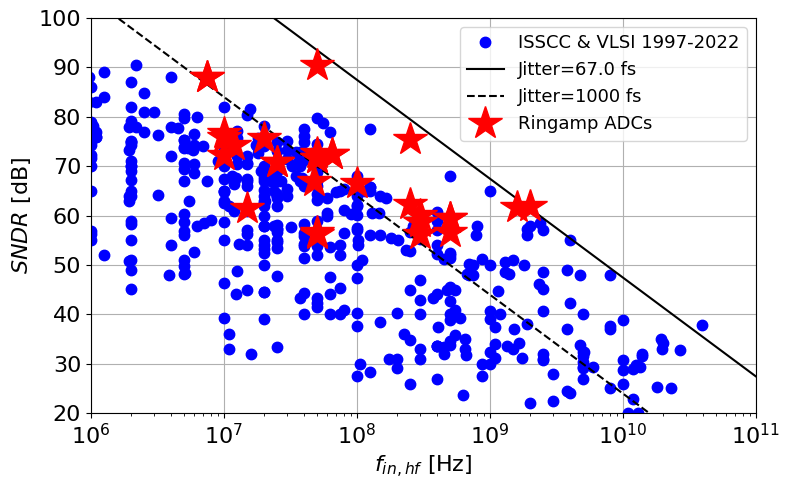

In [5]:
fig, ax = plt.subplots(figsize=size)
ax.plot(df['fin_hf [Hz]'], df['SNDR_hf [dB]'], 'b.', ms=15, label='ISSCC & VLSI 1997-%d' %max(df['YEAR']))
ax.plot(env_x, env_y1, 'k', label='Jitter=%.1f fs' %(jitter_min/1e-15))
ax.plot(env_x, env_y2, 'k--', label='Jitter=%.0f fs' %(jitter_max/1e-15))

ax.plot(ringampADC_xdata, ringampADC_ydata, 'r*', ms=25, label='Ringamp ADCs')

ax.legend(frameon=1, fontsize=font-3)
ax.set_xscale('log')
ax.set_xlim((1e6, 1e11))
ax.set_ylim((20, 100))
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.xlabel('$f_{in,hf}$ [Hz]', fontsize=font)
plt.ylabel('$SNDR$ [dB]', fontsize=font)
plt.grid(True)
fig.tight_layout()
plt.show()

In [6]:
# save as high-resolution png file
fig.savefig("aperture_plot.png", dpi=600)